## Section 1: Environment Setup & Dataset Loading

In [ ]:
# Detect environment and configure paths
import sys
import os
from pathlib import Path

# Detect Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running on Google Colab")
except:
    IN_COLAB = False
    print("✓ Running locally")

# Set up paths
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = '/content/AMLProject'
    DATA_ROOT = '/content/drive/MyDrive/AMLProject/data'
else:
    PROJECT_ROOT = os.getcwd()
    DATA_ROOT = os.path.join(PROJECT_ROOT, 'data')

# Create necessary directories
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, 'checkpoints')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'outputs', 'dinov2')
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

for directory in [CHECKPOINT_DIR, OUTPUT_DIR, MODEL_DIR, DATA_ROOT]:
    os.makedirs(directory, exist_ok=True)

print(f"\nProject root: {PROJECT_ROOT}")
print(f"Data root: {DATA_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

✓ Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Project root: /content/AMLProject
Data root: /content/drive/MyDrive/AMLProject/data
Output directory: /content/AMLProject/outputs/dinov2


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def window_soft_argmax(similarity, H, W, window=7, tau=0.05):
    """
    Window soft-argmax for sub-pixel coordinate prediction.

    Args:
        similarity: [N, H*W] or [N, H, W] similarity scores
        H, W: Grid dimensions
        window: Window size around peak (odd number)
        tau: Temperature for softmax (lower = sharper)

    Returns:
        [N, 2] tensor with (y, x) coordinates in patch space
    """
    if similarity.dim() == 2:
        N = similarity.size(0)
        sim2d = similarity.view(N, H, W)
    elif similarity.dim() == 3:
        N = similarity.size(0)
        sim2d = similarity
    else:
        raise ValueError("similarity must be [N,H*W] or [N,H,W]")

    r = window // 2
    preds = []

    for i in range(N):
        s = sim2d[i]  # [H, W]

        # Find peak with argmax
        idx = torch.argmax(s)
        y0 = (idx // W).item()
        x0 = (idx % W).item()

        # Extract window around peak
        y1, y2 = max(y0 - r, 0), min(y0 + r + 1, H)
        x1, x2 = max(x0 - r, 0), min(x0 + r + 1, W)

        sub = s[y1:y2, x1:x2]

        # Create coordinate grids
        yy, xx = torch.meshgrid(
            torch.arange(y1, y2, device=s.device, dtype=torch.float32),
            torch.arange(x1, x2, device=s.device, dtype=torch.float32),
            indexing='ij'
        )

        # Soft-argmax within window
        wts = torch.softmax(sub.flatten() / tau, dim=0).view_as(sub)
        y_hat = (wts * yy).sum()
        x_hat = (wts * xx).sum()

        preds.append(torch.stack([y_hat, x_hat]))

    return torch.stack(preds, dim=0)  # [N, 2]


def unfreeze_last_k_blocks(model, k, blocks_attr='blocks'):
    """
    Unfreeze the last k transformer blocks of a model.

    Args:
        model: The backbone model
        k: Number of last blocks to unfreeze
        blocks_attr: Attribute name for blocks (default 'blocks')

    Returns:
        List of trainable parameters
    """
    # Freeze all parameters
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze last k blocks
    blocks = getattr(model, blocks_attr)
    for block in blocks[-k:]:
        for p in block.parameters():
            p.requires_grad = True

    # Return trainable parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"Unfroze last {k} blocks: {len(trainable_params)} trainable parameters")

    return trainable_params


def compute_keypoint_loss(sim2d, H, W, gt_xy_px, patch_size, use_soft=True, window=7, tau=0.05):
    """
    Compute loss from similarity map to ground truth keypoint.

    Args:
        sim2d: [H, W] similarity map
        H, W: Grid dimensions
        gt_xy_px: [2] ground truth coordinates in pixels (y, x)
        patch_size: Patch size for coordinate conversion
        use_soft: Use soft-argmax (True) or argmax (False)
        window, tau: Soft-argmax parameters

    Returns:
        Scalar loss
    """
    if use_soft:
        pred_xy_patch = window_soft_argmax(sim2d[None], H, W, window, tau)[0]
    else:
        idx = sim2d.argmax()
        pred_xy_patch = torch.stack([idx // W, idx % W]).float()

    pred_xy_px = (pred_xy_patch + 0.5) * patch_size

    return F.smooth_l1_loss(pred_xy_px, gt_xy_px)


print("✓ Utility functions loaded")

✓ Utility functions loaded


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json
import os
from torchvision import transforms

class SPairDataset(Dataset):
    """
    SPair-71k dataset with keypoint annotations for correspondence learning.
    """

    def __init__(self, root_dir, split='trn', category=None, image_size=224, subset=None):
        """
        Args:
            root_dir: Path to SPair-71k root directory
            split: 'trn', 'val', or 'test'
            category: Specific category or None for all
            image_size: Target image size for resizing
            subset: If int, use only first N samples (for debugging)
        """
        self.root_dir = root_dir
        self.split = split
        self.category = category
        self.image_size = image_size

        # Load pairs
        self.pairs = self._load_pairs()
        if subset is not None:
            self.pairs = self.pairs[:subset]

        # Image transforms
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print(f"SPair-71k {split} dataset: {len(self.pairs)} pairs loaded")

    def _load_pairs(self):
        """Load pair annotations from layout files."""
        pairs = []

        # Get layout files
        layout_dir = os.path.join(self.root_dir, 'Layout', self.split)

        if not os.path.exists(layout_dir):
            print(f"Warning: Layout directory not found: {layout_dir}")
            return pairs

        # Get all categories or specific one
        if self.category:
            categories = [self.category]
        else:
            categories = [d for d in os.listdir(layout_dir)
                         if os.path.isdir(os.path.join(layout_dir, d))]

        # Load pairs from each category
        for cat in categories:
            cat_dir = os.path.join(layout_dir, cat)
            if not os.path.exists(cat_dir):
                continue

            for fname in os.listdir(cat_dir):
                if not fname.endswith('.json'):
                    continue

                json_path = os.path.join(cat_dir, fname)
                try:
                    with open(json_path, 'r') as f:
                        pair_data = json.load(f)

                    # Extract pair info
                    pair = {
                        'category': cat,
                        'src_img': pair_data['src_imname'],
                        'tgt_img': pair_data['trg_imname'],
                        'src_kps': np.array(pair_data['src_kps']).reshape(-1, 2),
                        'tgt_kps': np.array(pair_data['trg_kps']).reshape(-1, 2),
                        'src_bbox': pair_data.get('src_bndbox', None),
                        'tgt_bbox': pair_data.get('trg_bndbox', None),
                    }
                    pairs.append(pair)

                except Exception as e:
                    print(f"Error loading {json_path}: {e}")
                    continue

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        # Load images
        src_img_path = os.path.join(self.root_dir, 'JPEGImages',
                                    pair['category'], pair['src_img'])
        tgt_img_path = os.path.join(self.root_dir, 'JPEGImages',
                                    pair['category'], pair['tgt_img'])

        src_img_pil = Image.open(src_img_path).convert('RGB')
        tgt_img_pil = Image.open(tgt_img_path).convert('RGB')

        # Original sizes
        src_w, src_h = src_img_pil.size
        tgt_w, tgt_h = tgt_img_pil.size

        # Scale keypoints to match resized images
        src_kps = pair['src_kps'].copy().astype(float)
        tgt_kps = pair['tgt_kps'].copy().astype(float)

        src_kps[:, 0] *= self.image_size / src_w
        src_kps[:, 1] *= self.image_size / src_h
        tgt_kps[:, 0] *= self.image_size / tgt_w
        tgt_kps[:, 1] *= self.image_size / tgt_h

        # Transform images
        src_img = self.transform(src_img_pil)
        tgt_img = self.transform(tgt_img_pil)

        # Bounding boxes (scaled)
        if pair['src_bbox'] is not None:
            src_bbox = np.array(pair['src_bbox'])
            src_bbox[0::2] *= self.image_size / src_w
            src_bbox[1::2] *= self.image_size / src_h
            src_bbox_wh = np.array([src_bbox[2] - src_bbox[0],
                                   src_bbox[3] - src_bbox[1]])
        else:
            src_bbox_wh = np.array([self.image_size, self.image_size])

        if pair['tgt_bbox'] is not None:
            tgt_bbox = np.array(pair['tgt_bbox'])
            tgt_bbox[0::2] *= self.image_size / tgt_w
            tgt_bbox[1::2] *= self.image_size / tgt_h
            tgt_bbox_wh = np.array([tgt_bbox[2] - tgt_bbox[0],
                                   tgt_bbox[3] - tgt_bbox[1]])
        else:
            tgt_bbox_wh = np.array([self.image_size, self.image_size])

        return {
            'src_img': src_img,
            'tgt_img': tgt_img,
            'src_kps': torch.from_numpy(src_kps).float(),
            'tgt_kps': torch.from_numpy(tgt_kps).float(),
            'src_bbox_wh': torch.from_numpy(src_bbox_wh).float(),
            'tgt_bbox_wh': torch.from_numpy(tgt_bbox_wh).float(),
            'category': pair['category'],
            'pair_id': idx
        }


def create_spair_dataloaders(root_dir, batch_size=1, num_workers=2,
                             train_subset=None, val_subset=None):
    """
    Create SPair-71k dataloaders for training and validation.

    Args:
        root_dir: Path to SPair-71k directory
        batch_size: Batch size (typically 1 for correspondence)
        num_workers: Number of data loading workers
        train_subset: If int, limit training samples
        val_subset: If int, limit validation samples

    Returns:
        train_loader, val_loader
    """
    train_dataset = SPairDataset(root_dir, split='trn', subset=train_subset)
    val_dataset = SPairDataset(root_dir, split='val', subset=val_subset)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader


print("✓ SPair-71k dataloader ready")

✓ SPair-71k dataloader ready


## SPair-71k Dataloader

Complete dataloader for SPair-71k with keypoint annotations for finetuning.

## Utility Functions

Window soft-argmax for sub-pixel refinement and finetuning utilities.

In [ ]:
# ========== CONFIGURATION FLAGS ==========
# Set these flags to control behavior
ENABLE_FINETUNING = False  # Set True to enable light finetuning of last layers
USE_SOFT_ARGMAX = False    # Set True to use window soft-argmax instead of argmax

# Finetuning hyperparameters (only used if ENABLE_FINETUNING=True)
FINETUNE_K_LAYERS = 2      # Number of last transformer blocks to unfreeze {1, 2, 4}
FINETUNE_LR = 1e-5         # Learning rate
FINETUNE_WD = 1e-4         # Weight decay
FINETUNE_EPOCHS = 3        # Number of training epochs
FINETUNE_BATCH_SIZE = 1    # Batch size for training
FINETUNE_TRAIN_SUBSET = None  # None for full training set, or int for subset

# Soft-argmax hyperparameters (only used if USE_SOFT_ARGMAX=True)
SOFT_WINDOW = 7            # Window size around peak (odd number: 5, 7, 9)
SOFT_TAU = 0.05            # Softmax temperature (lower = sharper)

print(f"Configuration:")
print(f"  ENABLE_FINETUNING = {ENABLE_FINETUNING}")
print(f"  USE_SOFT_ARGMAX = {USE_SOFT_ARGMAX}")
if ENABLE_FINETUNING:
    print(f"  Finetuning: k={FINETUNE_K_LAYERS}, lr={FINETUNE_LR}, epochs={FINETUNE_EPOCHS}")
if USE_SOFT_ARGMAX:
    print(f"  Soft-argmax: window={SOFT_WINDOW}, tau={SOFT_TAU}")

Configuration:
  ENABLE_FINETUNING = False
  USE_SOFT_ARGMAX = False


## Configuration Flags

Set these flags to control the pipeline behavior:
- `ENABLE_FINETUNING`: Enable light finetuning of last transformer blocks
- `USE_SOFT_ARGMAX`: Use window soft-argmax instead of argmax for prediction

In [ ]:
# Install dependencies
import subprocess

print("Installing required packages...")
packages = [
    'torch',
    'torchvision',
    'numpy',
    'matplotlib',
    'opencv-python',
    'pillow',
    'scipy',
    'tqdm',
    'pandas',
    'scikit-learn'
]

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', '--upgrade'] + packages)
print("✓ All packages installed successfully!")

Installing required packages...
✓ All packages installed successfully!


In [ ]:
# Install/Reinstall problematic packages to fix potential conflicts
import subprocess
import sys

print("Attempting a more aggressive reinstallation of numpy, scipy, and scikit-learn...")

# First, uninstall in reverse order of dependency
print("Uninstalling scikit-learn...")
subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'scikit-learn'])
print("Uninstalling scipy...")
subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'scipy'])
print("Uninstalling numpy...")
subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'numpy'])


# Then, install 'scikit-learn' and let pip resolve its dependencies (numpy, scipy)
# This should install the latest compatible versions for the current Python environment.
print("Installing scikit-learn (pip will resolve numpy and scipy versions)...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'scikit-learn'])

print("Aggressive reinstallation complete. It is HIGHLY recommended to restart the runtime now.")

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
import json
import pandas as pd
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import importlib

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Detect device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

print(f"PyTorch version: {torch.__version__}")

Attempting a more aggressive reinstallation of numpy, scipy, and scikit-learn...
Uninstalling scikit-learn...
Uninstalling scipy...
Uninstalling numpy...
Installing scikit-learn (pip will resolve numpy and scipy versions)...
Aggressive reinstallation complete. It is HIGHLY recommended to restart the runtime now.
✓ Using CUDA GPU: Tesla T4
PyTorch version: 2.9.1+cu128


In [ ]:
# Download SPair-71k dataset (if not already present)
import requests
import tarfile
from tqdm import tqdm as tqdm_requests

data_path = os.path.join(DATA_ROOT, 'SPair-71k')

if not os.path.exists(data_path):
    print("Downloading SPair-71k dataset...")
    url = "http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz"
    tar_path = os.path.join(DATA_ROOT, 'SPair-71k.tar.gz')

    # Download with progress bar
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(tar_path, 'wb') as f, tqdm_requests(
        desc='Downloading',
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for data in response.iter_content(chunk_size=1024):
            size = f.write(data)
            pbar.update(size)

    print("\nExtracting...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(DATA_ROOT)

    # Cleanup
    os.remove(tar_path)
    print("✓ Extraction complete")
else:
    print(f"✓ SPair-71k dataset already exists at {data_path}")

✓ SPair-71k dataset already exists at /content/drive/MyDrive/AMLProject/data/SPair-71k


In [ ]:
import os, sys, shutil, importlib
#UTILE PER IMPORTARE REPO SD4Match

# --- Configurazione path progetto ---
PROJECT_ROOT = "/content/drive/MyDrive/AMLProject"  # oppure in Drive se vuoi persistenza
repo_path = os.path.join(PROJECT_ROOT, "SD4Match")

os.makedirs(PROJECT_ROOT, exist_ok=True)

# --- Scarica SD4Match se manca ---
if not os.path.exists(repo_path):
    print("📦 Downloading SD4Match repository from ActiveVisionLab...")

    # URL zip della repo corretta
    zip_url = "https://github.com/ActiveVisionLab/SD4Match/archive/refs/heads/main.zip"
    zip_path = os.path.join(PROJECT_ROOT, "SD4Match.zip")

    # download
    import requests
    r = requests.get(zip_url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    # estrai il zip
    import zipfile
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(PROJECT_ROOT)

    # sposta e rinomina
    extracted = os.path.join(PROJECT_ROOT, "SD4Match-main")
    if os.path.exists(repo_path):
        shutil.rmtree(repo_path)
    os.rename(extracted, repo_path)
    os.remove(zip_path)

    print("✓ Repository SD4Match ready at", repo_path)

# --- Aggiungi a sys.path e importa ---
if repo_path not in sys.path:
    sys.path.append(repo_path)

try:
    module = importlib.import_module("dataset.spair")
    SPairDataset = getattr(module, "SPairDataset")
    print("✓ SPairDataset imported successfully!")
except Exception as e:
    print("❌ Import Error:", e)


✓ SPairDataset imported successfully!


In [ ]:
# Setup dataset path and import SPair dataset class
repo_path = os.path.join(PROJECT_ROOT, 'SD4Match')

if not os.path.exists(repo_path):
    print("WARNING: SD4Match repository not found!")
    print("Please ensure the SD4Match repository is cloned in the project directory.")
else:
    if repo_path not in sys.path:
        sys.path.append(repo_path)
    print(f"✓ SD4Match path added: {repo_path}")

# Import dataset class
try:
    module = importlib.import_module("dataset.spair")
    SPairDataset = getattr(module, "SPairDataset")
    print("✓ SPairDataset class imported successfully")
except Exception as e:
    print(f"Import Error: {e}")
    print("Make sure SD4Match repository is properly cloned.")

✓ SD4Match path added: /content/drive/MyDrive/AMLProject/SD4Match
✓ SPairDataset class imported successfully


In [ ]:
# Create configuration for dataset
class Config:
    def __init__(self):
        class DatasetConfig:
            def __init__(self):
                self.ROOT = DATA_ROOT
                self.NAME = 'spair'
                self.CATEGORY = 'cat'
                self.SIZE = 224
                self.IMG_SIZE = 224
                self.MEAN = [0.485, 0.456, 0.406]
                self.STD = [0.229, 0.224, 0.225]
        self.DATASET = DatasetConfig()

cfg = Config()
print(f"✓ Configuration created")
print(f"Dataset root: {cfg.DATASET.ROOT}")

✓ Configuration created
Dataset root: /content/drive/MyDrive/AMLProject/data


## Section 2: DINOv2 Model Loading

In [ ]:
# Load DINOv2 ViT-B/14 model
print("Loading DINOv2 ViT-B/14 model...")

try:
    # Try loading from torch hub
    dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
    dinov2_model = dinov2_model.to(device)
    dinov2_model.eval()

    print(f"✓ Model loaded successfully!")
    print(f"Model type: DINOv2 ViT-B/14")
    print(f"Feature dimension: {dinov2_model.embed_dim}")
    print(f"Patch size: 14x14")
    print(f"Image size: 224x224 → {224//14}x{224//14} = 256 patches")

except Exception as e:
    print(f"Error loading DINOv2: {e}")
    print("Make sure you have internet connection for the first load.")

Loading DINOv2 ViT-B/14 model...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 228MB/s]


✓ Model loaded successfully!
Model type: DINOv2 ViT-B/14
Feature dimension: 768
Patch size: 14x14
Image size: 224x224 → 16x16 = 256 patches


## Section 3: Feature Extractor Class

DINOv2 extracts dense patch features that capture semantic information. We'll create a feature extractor class that:
- Extracts 16×16 grid of features (patch tokens)
- Handles coordinate mapping between image and feature space
- Provides L2-normalized features for similarity computation

In [ ]:
class DINOv2FeatureExtractor:
    """
    Extract dense spatial features from DINOv2 for correspondence matching.

    Features:
    - Input: 224×224 RGB images
    - Output: 16×16×768 feature maps (for ViT-B/14)
    - Features are L2-normalized for cosine similarity
    """

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        # Feature dimensions
        self.patch_size = 14
        self.img_size = 224
        self.feat_h = self.feat_w = self.img_size // self.patch_size  # 16

    def extract_features(self, img):
        """
        Extract dense feature map from an image.

        Args:
            img: PIL Image or tensor [3, H, W]

        Returns:
            features: torch.Tensor [1, feat_h*feat_w, dim]
            features_2d: torch.Tensor [1, dim, feat_h, feat_w]
        """
        # Preprocess
        if isinstance(img, Image.Image):
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        else:
            img_tensor = img.unsqueeze(0).to(self.device) if img.dim() == 3 else img.to(self.device)

        # Extract features
        with torch.no_grad():
            # Get patch tokens (excluding CLS token)
            features_dict = self.model.forward_features(img_tensor)
            features = features_dict['x_norm_patchtokens']  # [1, num_patches, dim]

            # Reshape to spatial grid
            B, N, D = features.shape
            features_2d = features.reshape(B, self.feat_h, self.feat_w, D)
            features_2d = features_2d.permute(0, 3, 1, 2)  # [1, dim, feat_h, feat_w]

            # L2 normalize for cosine similarity
            features = F.normalize(features, p=2, dim=-1)
            features_2d = F.normalize(features_2d, p=2, dim=1)

        return features, features_2d

    def extract_keypoint_features(self, img, keypoints):
        """
        Extract features at specific keypoint locations.

        Args:
            img: PIL Image or tensor
            keypoints: numpy array [N, 2] in image coordinates (x, y)

        Returns:
            kp_features: torch.Tensor [N, dim]
        """
        _, features_2d = self.extract_features(img)  # [1, dim, feat_h, feat_w]

        # Map image coordinates to feature coordinates
        feat_coords = self.map_coords_to_features(keypoints)

        # Extract features using bilinear interpolation
        kp_features = []
        for x, y in feat_coords:
            if 0 <= x < self.feat_w and 0 <= y < self.feat_h:
                # Use bilinear interpolation for sub-pixel accuracy
                x0, y0 = int(np.floor(x)), int(np.floor(y))
                x1, y1 = min(x0 + 1, self.feat_w - 1), min(y0 + 1, self.feat_h - 1)

                # Interpolation weights
                wx = x - x0
                wy = y - y0

                # Bilinear interpolation
                feat = (1 - wx) * (1 - wy) * features_2d[0, :, y0, x0] + \
                       wx * (1 - wy) * features_2d[0, :, y0, x1] + \
                       (1 - wx) * wy * features_2d[0, :, y1, x0] + \
                       wx * wy * features_2d[0, :, y1, x1]

                kp_features.append(feat)
            else:
                # Out of bounds - use zero vector
                kp_features.append(torch.zeros(features_2d.shape[1], device=self.device))

        kp_features = torch.stack(kp_features)
        kp_features = F.normalize(kp_features, p=2, dim=-1)

        return kp_features

    def map_coords_to_features(self, coords):
        """
        Map image coordinates to feature map coordinates.

        Args:
            coords: numpy array [N, 2] in image space (x, y)

        Returns:
            feat_coords: numpy array [N, 2] in feature space
        """
        scale_x = self.feat_w / self.img_size
        scale_y = self.feat_h / self.img_size

        # Convert torch.Tensor to numpy array if it's a tensor
        if isinstance(coords, torch.Tensor):
            feat_coords = coords.cpu().numpy() # Convert to numpy on CPU
        else:
            feat_coords = coords.copy()

        feat_coords[:, 0] = coords[:, 0] * scale_x
        feat_coords[:, 1] = coords[:, 1] * scale_y

        return feat_coords

    def map_features_to_coords(self, feat_coords):
        """
        Map feature coordinates back to image space.

        Args:
            feat_coords: numpy array [N, 2] in feature space

        Returns:
            img_coords: numpy array [N, 2] in image space (x, y)
        """
        scale_x = self.img_size / self.feat_w
        scale_y = self.img_size / self.feat_h

        img_coords = feat_coords.copy()
        img_coords[:, 0] = feat_coords[:, 0] * scale_x
        img_coords[:, 1] = feat_coords[:, 1] * scale_y

        return img_coords

# Create feature extractor
feature_extractor = DINOv2FeatureExtractor(dinov2_model, device)
print("✓ Feature extractor created")

✓ Feature extractor created


## Section 4: Test Feature Extraction with Visualization

Let's test the feature extractor on a sample image pair and visualize the features.

In [ ]:
# Load test dataset
print("Loading SPair-71k test dataset...")
try:
    dataset = SPairDataset(cfg, 'test')
    print(f"✓ Successfully loaded {len(dataset)} test pairs")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Make sure dataset is properly extracted.")

Loading SPair-71k test dataset...
Reading SPair-71k information...


100%|██████████| 12234/12234 [56:21<00:00,  3.62it/s]

✓ Successfully loaded 12234 test pairs


In [ ]:
# Get a sample and extract features
sample_idx = 0
sample = dataset[sample_idx]

print(f"Extracting features for sample {sample_idx}...")

# Get images and keypoints
src_img = sample['src_img']
tgt_img = sample['trg_img']
src_kps = sample['src_kps']
tgt_kps = sample['trg_kps']

print(f"Source keypoints shape: {src_kps.shape}")
print(f"Target keypoints shape: {tgt_kps.shape}")

# Extract dense features
src_features, src_features_2d = feature_extractor.extract_features(src_img)
tgt_features, tgt_features_2d = feature_extractor.extract_features(tgt_img)

print(f"\nFeature shapes:")
print(f"Source features: {src_features.shape}")  # [1, 256, 768]
print(f"Source features 2D: {src_features_2d.shape}")  # [1, 768, 16, 16]
print(f"Target features: {tgt_features.shape}")
print(f"Target features 2D: {tgt_features_2d.shape}")

# Denormalize function for visualization
def denorm_show(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    return np.clip(img, 0, 1)

Extracting features for sample 0...
Source keypoints shape: torch.Size([20, 2])
Target keypoints shape: torch.Size([20, 2])

Feature shapes:
Source features: torch.Size([1, 256, 768])
Source features 2D: torch.Size([1, 768, 16, 16])
Target features: torch.Size([1, 256, 768])
Target features 2D: torch.Size([1, 768, 16, 16])


In [ ]:
if ENABLE_FINETUNING:
    print("=" * 60)
    print("LIGHT FINETUNING ENABLED")
    print("=" * 60)

    # Path to SPair-71k
    SPAIR_ROOT = os.path.join(DATA_ROOT, 'SPair-71k')

    if not os.path.exists(SPAIR_ROOT):
        print(f"\n⚠️  SPair-71k not found at: {SPAIR_ROOT}")
        print("   Please download SPair-71k and place it in the data directory")
        print("   Download from: http://cvlab.postech.ac.kr/research/SPair-71k/")
    else:
        # Create dataloaders
        print(f"\nLoading SPair-71k from: {SPAIR_ROOT}")
        train_loader, val_loader = create_spair_dataloaders(
            SPAIR_ROOT,
            batch_size=FINETUNE_BATCH_SIZE,
            num_workers=2,
            train_subset=FINETUNE_TRAIN_SUBSET,
            val_subset=500  # Use 500 samples for validation
        )

        # Unfreeze last k blocks
        trainable_params = unfreeze_last_k_blocks(dinov2_model, FINETUNE_K_LAYERS, blocks_attr='blocks')

        # Setup optimizer
        optimizer = torch.optim.AdamW(trainable_params, lr=FINETUNE_LR, weight_decay=FINETUNE_WD)

        print(f"\nFinetuning configuration:")
        print(f"  k={FINETUNE_K_LAYERS} layers")
        print(f"  lr={FINETUNE_LR}, wd={FINETUNE_WD}")
        print(f"  epochs={FINETUNE_EPOCHS}")
        print(f"  batch_size={FINETUNE_BATCH_SIZE}")
        print(f"  train samples: {len(train_loader.dataset)}")
        print(f"  val samples: {len(val_loader.dataset)}")

        # Get patch size from model
        patch_size = 14  # DINOv2 ViT-B/14

        # Training loop
        dinov2_model.train()
        best_val_loss = float('inf')

        for epoch in range(FINETUNE_EPOCHS):
            # Training
            epoch_loss = 0.0
            num_batches = 0

            for batch_idx, batch in enumerate(train_loader):
                src_img = batch['src_img'].cuda()
                tgt_img = batch['tgt_img'].cuda()
                src_kps = batch['src_kps'].cuda()
                tgt_kps = batch['tgt_kps'].cuda()

                # Extract features from model
                with torch.no_grad() if epoch == 0 else torch.enable_grad():
                    # Get patch tokens
                    src_out = dinov2_model.forward_features(src_img)
                    tgt_out = dinov2_model.forward_features(tgt_img)

                    # Extract patch tokens (skip CLS token)
                    if isinstance(src_out, dict):
                        src_feats = src_out['x_norm_patchtokens']
                        tgt_feats = tgt_out['x_norm_patchtokens']
                    else:
                        src_feats = src_out[:, 1:, :]  # Skip CLS
                        tgt_feats = tgt_out[:, 1:, :]

                B = src_img.size(0)
                # Calculate grid size
                num_patches = src_feats.size(1)
                grid_size = int(np.sqrt(num_patches))
                Hs = Ws = Ht = Wt = grid_size

                # Compute loss over keypoints
                batch_loss = 0.0
                num_kps = 0

                for b in range(B):
                    src_f = src_feats[b]  # [Ns, C]
                    tgt_f = tgt_feats[b]  # [Nt, C]

                    # Normalize features
                    src_f = F.normalize(src_f, dim=-1)
                    tgt_f = F.normalize(tgt_f, dim=-1)

                    # For each source keypoint
                    N_kp = src_kps[b].size(0)
                    for kp_idx in range(N_kp):
                        # Map keypoint to patch index
                        src_x = src_kps[b][kp_idx, 0].item()
                        src_y = src_kps[b][kp_idx, 1].item()

                        # Convert to patch coordinates
                        src_px = int(src_x / patch_size)
                        src_py = int(src_y / patch_size)

                        # Clamp to valid range
                        src_px = max(0, min(Ws - 1, src_px))
                        src_py = max(0, min(Hs - 1, src_py))

                        src_patch_idx = src_py * Ws + src_px

                        # Compute similarity with target
                        sim = torch.matmul(tgt_f, src_f[src_patch_idx])  # [Nt]
                        sim_2d = sim.view(Ht, Wt)

                        # Compute loss
                        gt_xy = tgt_kps[b][kp_idx]  # [2] in (x, y) format
                        gt_yx = torch.stack([gt_xy[1], gt_xy[0]])  # Convert to (y, x)

                        loss = compute_keypoint_loss(
                            sim_2d, Ht, Wt, gt_yx, patch_size,
                            use_soft=True, window=SOFT_WINDOW, tau=SOFT_TAU
                        )
                        batch_loss += loss
                        num_kps += 1

                if num_kps > 0:
                    batch_loss = batch_loss / num_kps

                    # Backward pass
                    optimizer.zero_grad()
                    batch_loss.backward()
                    optimizer.step()

                    epoch_loss += batch_loss.item()
                    num_batches += 1

                if (batch_idx + 1) % 50 == 0:
                    avg_batch_loss = epoch_loss / max(1, num_batches)
                    print(f"  Epoch {epoch+1}/{FINETUNE_EPOCHS}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {avg_batch_loss:.4f}")

            avg_train_loss = epoch_loss / max(1, num_batches)

            # Validation
            dinov2_model.eval()
            val_loss = 0.0
            val_batches = 0

            with torch.no_grad():
                for batch in val_loader:
                    src_img = batch['src_img'].cuda()
                    tgt_img = batch['tgt_img'].cuda()
                    src_kps = batch['src_kps'].cuda()
                    tgt_kps = batch['tgt_kps'].cuda()

                    # Extract features
                    src_out = dinov2_model.forward_features(src_img)
                    tgt_out = dinov2_model.forward_features(tgt_img)

                    if isinstance(src_out, dict):
                        src_feats = src_out['x_norm_patchtokens']
                        tgt_feats = tgt_out['x_norm_patchtokens']
                    else:
                        src_feats = src_out[:, 1:, :]
                        tgt_feats = tgt_out[:, 1:, :]

                    num_patches = src_feats.size(1)
                    grid_size = int(np.sqrt(num_patches))

                    # Compute validation loss (same as training)
                    batch_val_loss = 0.0
                    num_kps = 0

                    for b in range(src_img.size(0)):
                        src_f = F.normalize(src_feats[b], dim=-1)
                        tgt_f = F.normalize(tgt_feats[b], dim=-1)

                        for kp_idx in range(src_kps[b].size(0)):
                            src_x = int(src_kps[b][kp_idx, 0].item() / patch_size)
                            src_y = int(src_kps[b][kp_idx, 1].item() / patch_size)
                            src_x = max(0, min(grid_size - 1, src_x))
                            src_y = max(0, min(grid_size - 1, src_y))

                            src_patch_idx = src_y * grid_size + src_x
                            sim = torch.matmul(tgt_f, src_f[src_patch_idx])
                            sim_2d = sim.view(grid_size, grid_size)

                            gt_xy = tgt_kps[b][kp_idx]
                            gt_yx = torch.stack([gt_xy[1], gt_xy[0]])

                            loss = compute_keypoint_loss(
                                sim_2d, grid_size, grid_size, gt_yx, patch_size,
                                use_soft=True, window=SOFT_WINDOW, tau=SOFT_TAU
                            )
                            batch_val_loss += loss
                            num_kps += 1

                    if num_kps > 0:
                        val_loss += (batch_val_loss / num_kps).item()
                        val_batches += 1

            avg_val_loss = val_loss / max(1, val_batches)

            print(f"\nEpoch {epoch+1}/{FINETUNE_EPOCHS} Summary:")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Val Loss: {avg_val_loss:.4f}")

            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                checkpoint_path = os.path.join(OUTPUT_DIR, f'dinov2_finetuned_k{FINETUNE_K_LAYERS}_best.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': dinov2_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'config': {
                        'k_layers': FINETUNE_K_LAYERS,
                        'lr': FINETUNE_LR,
                        'wd': FINETUNE_WD,
                        'soft_window': SOFT_WINDOW,
                        'soft_tau': SOFT_TAU
                    }
                }, checkpoint_path)
                print(f"  ✓ Best model saved to: {checkpoint_path}")

            dinov2_model.train()

        dinov2_model.eval()
        print("\n" + "=" * 60)
        print("FINETUNING COMPLETED!")
        print("=" * 60)
        print(f"Best validation loss: {best_val_loss:.4f}")

else:
    print("Finetuning disabled. Using pretrained weights only.")

Finetuning disabled. Using pretrained weights only.


## Light Finetuning (Optional)

If `ENABLE_FINETUNING=True`, this section finetunes the last k transformer blocks on SPair-71k with keypoint supervision.

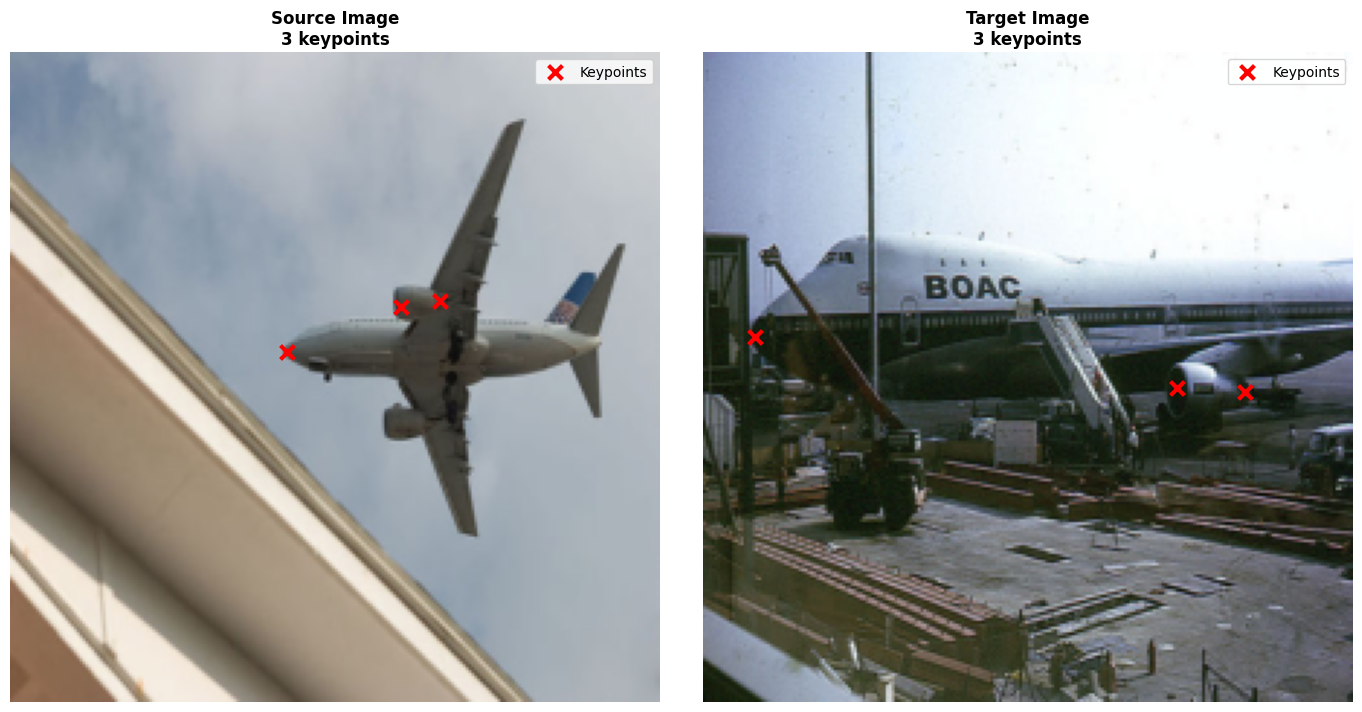

✓ Visualization saved to /content/AMLProject/outputs/dinov2


In [ ]:
# Visualize images with keypoints
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Source image
axes[0].imshow(denorm_show(src_img))
valid_src_kps = src_kps[src_kps[:, 0] >= 0]
axes[0].scatter(valid_src_kps[:, 0], valid_src_kps[:, 1],
               c='red', s=100, marker='x', linewidths=3, label='Keypoints')
axes[0].set_title(f'Source Image\n{len(valid_src_kps)} keypoints', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[0].legend()

# Target image
axes[1].imshow(denorm_show(tgt_img))
valid_tgt_kps = tgt_kps[tgt_kps[:, 0] >= 0]
axes[1].scatter(valid_tgt_kps[:, 0], valid_tgt_kps[:, 1],
               c='red', s=100, marker='x', linewidths=3, label='Keypoints')
axes[1].set_title(f'Target Image\n{len(valid_tgt_kps)} keypoints', fontsize=12, fontweight='bold')
axes[1].axis('off')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_images_with_keypoints.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to {OUTPUT_DIR}")

Visualizing DINOv2 features with PCA...


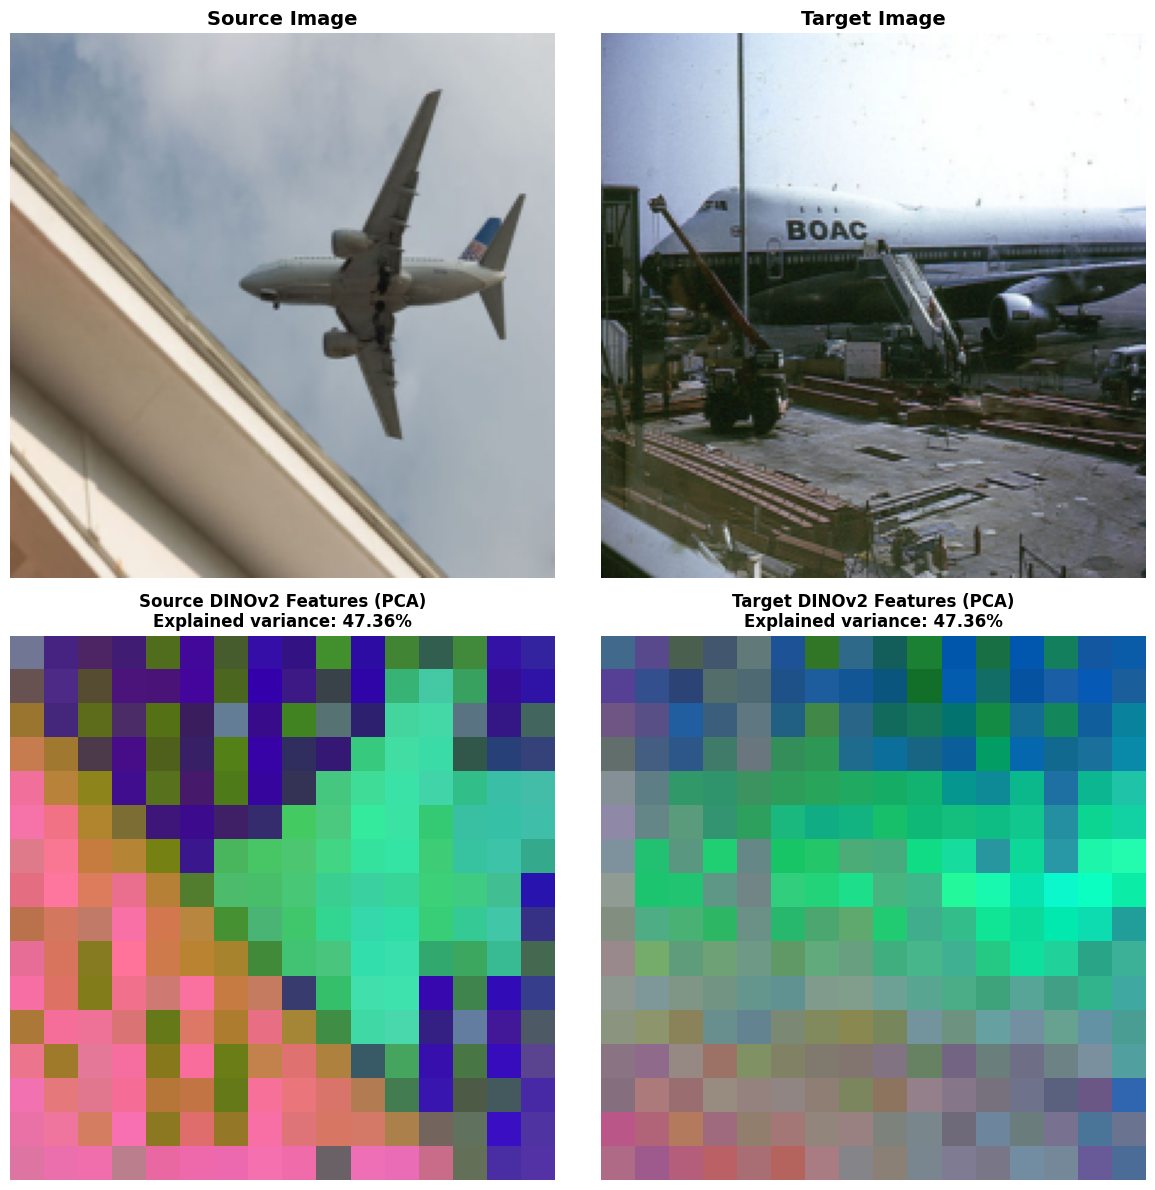


✓ PCA captures 47.36% of feature variance
Colors represent semantic regions learned by DINOv2


In [ ]:
# Visualize DINOv2 features using PCA
print("Visualizing DINOv2 features with PCA...")

# Get features as numpy arrays
src_feat_np = src_features[0].cpu().numpy()  # [256, 768]
tgt_feat_np = tgt_features[0].cpu().numpy()  # [256, 768]

# Apply PCA to reduce to 3 components for RGB visualization
pca = PCA(n_components=3)
src_pca = pca.fit_transform(src_feat_np)  # [256, 3]
tgt_pca = pca.transform(tgt_feat_np)  # [256, 3]

# Reshape to spatial grid
src_pca_img = src_pca.reshape(16, 16, 3)
tgt_pca_img = tgt_pca.reshape(16, 16, 3)

# Normalize to [0, 1] for visualization
src_pca_img = (src_pca_img - src_pca_img.min()) / (src_pca_img.max() - src_pca_img.min())
tgt_pca_img = (tgt_pca_img - tgt_pca_img.min()) / (tgt_pca_img.max() - tgt_pca_img.min())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original images
axes[0, 0].imshow(denorm_show(src_img))
axes[0, 0].set_title('Source Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(denorm_show(tgt_img))
axes[0, 1].set_title('Target Image', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# PCA visualizations
axes[1, 0].imshow(src_pca_img)
axes[1, 0].set_title(f'Source DINOv2 Features (PCA)\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}',
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(tgt_pca_img)
axes[1, 1].set_title(f'Target DINOv2 Features (PCA)\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}',
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'pca_feature_visualization.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ PCA captures {pca.explained_variance_ratio_.sum():.2%} of feature variance")
print("Colors represent semantic regions learned by DINOv2")

Computing patch-to-patch similarity...


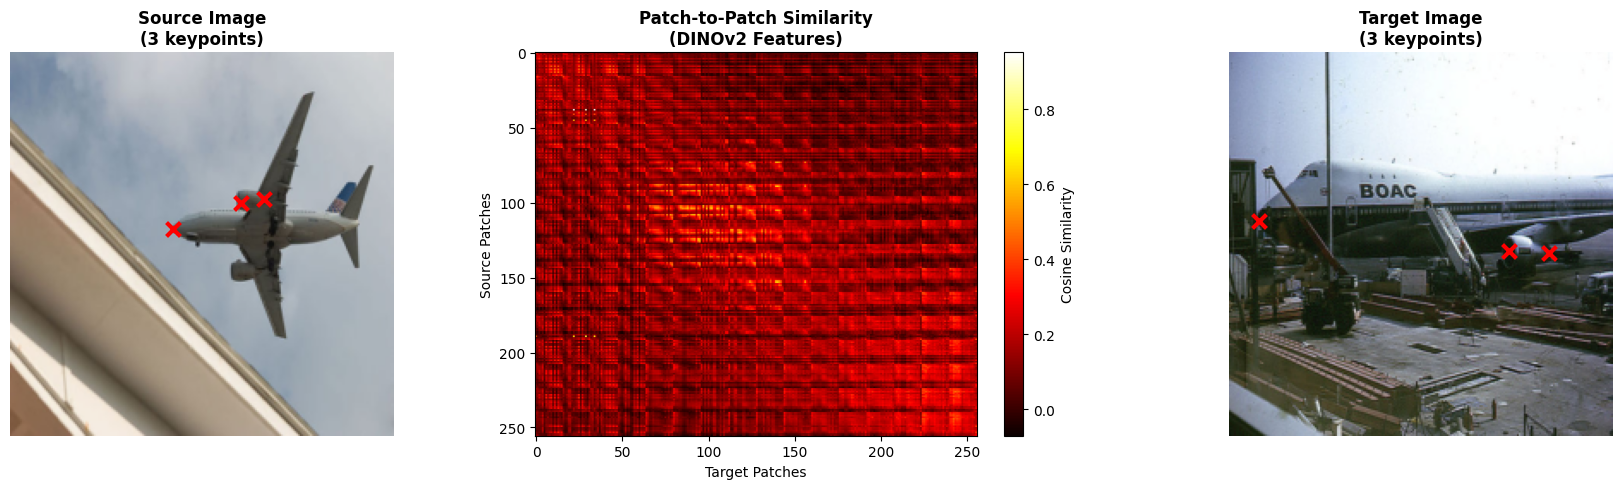


Similarity statistics:
  Mean: 0.1343
  Max: 0.9523
  Min: -0.0709
  High similarity (>0.9): 3 patch pairs


In [ ]:
# Compute patch-to-patch similarity matrix
print("Computing patch-to-patch similarity...")

# Normalize features for cosine similarity
src_feat_norm = F.normalize(torch.from_numpy(src_feat_np), dim=1)  # [256, 768]
tgt_feat_norm = F.normalize(torch.from_numpy(tgt_feat_np), dim=1)  # [256, 768]

# Compute similarity matrix
similarity_matrix = torch.mm(src_feat_norm, tgt_feat_norm.t()).numpy()  # [256, 256]

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Source image
axes[0].imshow(denorm_show(src_img))
axes[0].scatter(valid_src_kps[:, 0], valid_src_kps[:, 1],
               c='red', s=100, marker='x', linewidths=3)
axes[0].set_title(f'Source Image\n({len(valid_src_kps)} keypoints)', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Similarity heatmap
im = axes[1].imshow(similarity_matrix, cmap='hot', aspect='auto')
axes[1].set_title(f'Patch-to-Patch Similarity\n(DINOv2 Features)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Target Patches')
axes[1].set_ylabel('Source Patches')
plt.colorbar(im, ax=axes[1], label='Cosine Similarity')

# Target image
axes[2].imshow(denorm_show(tgt_img))
axes[2].scatter(valid_tgt_kps[:, 0], valid_tgt_kps[:, 1],
               c='red', s=100, marker='x', linewidths=3)
axes[2].set_title(f'Target Image\n({len(valid_tgt_kps)} keypoints)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'similarity_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSimilarity statistics:")
print(f"  Mean: {similarity_matrix.mean():.4f}")
print(f"  Max: {similarity_matrix.max():.4f}")
print(f"  Min: {similarity_matrix.min():.4f}")
print(f"  High similarity (>0.9): {(similarity_matrix > 0.9).sum()} patch pairs")

## Section 5: Correspondence Matcher

Now let's implement the correspondence matcher that finds matching keypoints between images.

In [ ]:
class CorrespondenceMatcher:
    """
    Find correspondences between source and target images using feature similarity.

    Methods:
    - Nearest Neighbor (NN): Find target point with highest similarity
    - Mutual Nearest Neighbors (MNN): Enforce bidirectional consistency
    - Ratio Test: Reject ambiguous matches (Lowe's ratio test)
    """

    def __init__(self, mutual_nn=False, ratio_threshold=None):
        """
        Args:
            mutual_nn: If True, only keep mutual nearest neighbors
            ratio_threshold: If set, apply ratio test (e.g., 0.8)
        """
        self.mutual_nn = mutual_nn
        self.ratio_threshold = ratio_threshold

    def match_keypoints(self, src_features, tgt_features_2d, src_keypoints,
                       feature_extractor):
        """
        Find correspondences for source keypoints in target image.

        Args:
            src_features: Source keypoint features [N, dim]
            tgt_features_2d: Target dense features [1, dim, H, W]
            src_keypoints: Source keypoint coordinates [N, 2]
            feature_extractor: Feature extractor instance

        Returns:
            pred_keypoints: Predicted target coordinates [N, 2]
            confidences: Match confidence scores [N]
        """
        N = src_features.shape[0]
        _, D, H, W = tgt_features_2d.shape

        # Reshape target features to [H*W, D]
        tgt_features_flat = tgt_features_2d.reshape(D, H * W).t()  # [H*W, D]

        # Compute similarity: [N, H*W]
        similarities = torch.mm(src_features, tgt_features_flat.t())

        # Find best matches
        max_sims, max_indices = similarities.max(dim=1)

        # Apply ratio test if specified
        if self.ratio_threshold is not None:
            # Get second best matches
            sorted_sims, _ = similarities.sort(dim=1, descending=True)
            ratios = sorted_sims[:, 0] / (sorted_sims[:, 1] + 1e-8)

            # Mark low-confidence matches
            valid_mask = ratios > self.ratio_threshold
            max_sims = max_sims * valid_mask.float()

        # Convert flat indices to 2D coordinates
        pred_y = (max_indices // W).float()
        pred_x = (max_indices % W).float()
        pred_coords_feat = torch.stack([pred_x, pred_y], dim=1).cpu().numpy()

        # Map to image coordinates
        pred_keypoints = feature_extractor.map_features_to_coords(pred_coords_feat)
        confidences = max_sims.cpu().numpy()

        # Apply mutual nearest neighbors if specified
        if self.mutual_nn:
            # Find reverse matches (target → source)
            reverse_sims = similarities.t()  # [H*W, N]
            _, reverse_indices = reverse_sims.max(dim=1)

            # Check mutual consistency
            forward_indices = max_indices.cpu().numpy()
            reverse_map = reverse_indices.cpu().numpy()

            for i in range(N):
                target_idx = forward_indices[i]
                if reverse_map[target_idx] != i:
                    # Not mutually consistent
                    confidences[i] = 0.0

        return pred_keypoints, confidences

    def match_images(self, src_img, tgt_img, src_keypoints, feature_extractor):
        """
        Complete matching pipeline for an image pair.

        Args:
            src_img: Source image tensor
            tgt_img: Target image tensor
            src_keypoints: Source keypoint coordinates [N, 2]
            feature_extractor: Feature extractor instance

        Returns:
            pred_keypoints: Predicted target keypoints [N, 2]
            confidences: Match confidence scores [N]
        """
        # Extract features
        src_kp_features = feature_extractor.extract_keypoint_features(src_img, src_keypoints)
        _, tgt_features_2d = feature_extractor.extract_features(tgt_img)

        # Match
        pred_keypoints, confidences = self.match_keypoints(
            src_kp_features, tgt_features_2d, src_keypoints, feature_extractor
        )

        return pred_keypoints, confidences

# Create matcher
matcher = CorrespondenceMatcher(mutual_nn=False, ratio_threshold=None)
print("✓ Correspondence matcher created")
print(f"  Mutual NN: {matcher.mutual_nn}")
print(f"  Ratio test: {matcher.ratio_threshold}")

✓ Correspondence matcher created
  Mutual NN: False
  Ratio test: None


## Section 6: PCK Evaluator

Implement PCK (Percentage of Correct Keypoints) evaluation metric.

In [ ]:
class PCKEvaluator:
    """
    Evaluate correspondence quality using PCK (Percentage of Correct Keypoints).

    A keypoint is correct if:
        ||predicted - ground_truth|| ≤ α × bbox_diagonal

    Standard thresholds: α ∈ {0.05, 0.10, 0.15}
    """

    def __init__(self, alpha_values=[0.05, 0.10, 0.15]):
        """
        Args:
            alpha_values: List of PCK thresholds
        """
        self.alpha_values = alpha_values

    def compute_pck(self, pred_kps, gt_kps, bbox=None, img_size=(224, 224)):
        """
        Compute PCK for a single image pair.

        Args:
            pred_kps: Predicted keypoints [N, 2]
            gt_kps: Ground truth keypoints [N, 2]
            bbox: Bounding box [4] as [x1, y1, x2, y2] (optional)
            img_size: Image size (H, W) for normalization if no bbox

        Returns:
            pck_dict: Dictionary with PCK@alpha for each threshold
            distances: Normalized distances for each keypoint
        """
        # Filter valid keypoints (ground truth with positive coordinates)
        valid_mask = (gt_kps[:, 0] >= 0) & (gt_kps[:, 1] >= 0)

        if valid_mask.sum() == 0:
            # No valid keypoints
            return {f'pck@{alpha:.2f}': 0.0 for alpha in self.alpha_values}, np.array([])

        pred_valid = pred_kps[valid_mask]
        gt_valid = gt_kps[valid_mask]

        # Compute distances
        distances = np.linalg.norm(pred_valid - gt_valid, axis=1)

        # Compute normalization factor
        if bbox is not None:
            # Use bounding box diagonal
            bbox_w = bbox[2] - bbox[0]
            bbox_h = bbox[3] - bbox[1]
            norm_factor = np.sqrt(bbox_w ** 2 + bbox_h ** 2)
        else:
            # Use image diagonal
            norm_factor = np.sqrt(img_size[0] ** 2 + img_size[1] ** 2)

        # Normalize distances
        normalized_distances = distances / (norm_factor + 1e-8)

        # Compute PCK for each threshold
        pck_dict = {}
        for alpha in self.alpha_values:
            correct = (normalized_distances <= alpha).sum()
            pck = correct / len(normalized_distances)
            pck_dict[f'pck@{alpha:.2f}'] = pck

        return pck_dict, normalized_distances

    def evaluate_dataset(self, predictions, ground_truths, bboxes=None):
        """
        Evaluate PCK over entire dataset.

        Args:
            predictions: List of predicted keypoints [N_samples, N_kps, 2]
            ground_truths: List of ground truth keypoints [N_samples, N_kps, 2]
            bboxes: List of bounding boxes (optional)

        Returns:
            avg_pck: Dictionary with average PCK across dataset
            per_sample_pck: List of per-sample PCK dictionaries
        """
        per_sample_pck = []
        all_distances = []

        for i in range(len(predictions)):
            bbox = bboxes[i] if bboxes is not None else None
            pck_dict, distances = self.compute_pck(predictions[i], ground_truths[i], bbox)
            per_sample_pck.append(pck_dict)
            all_distances.extend(distances.tolist())

        # Compute average PCK
        avg_pck = {}
        for alpha in self.alpha_values:
            key = f'pck@{alpha:.2f}'
            avg_pck[key] = np.mean([sample[key] for sample in per_sample_pck])

        return avg_pck, per_sample_pck, np.array(all_distances)

# Create evaluator
evaluator = PCKEvaluator(alpha_values=[0.05, 0.10, 0.15])
print("✓ PCK evaluator created")
print(f"  Alpha values: {evaluator.alpha_values}")

✓ PCK evaluator created
  Alpha values: [0.05, 0.1, 0.15]


## Section 7: Test on Sample

Let's test the complete pipeline on our sample image pair.

Matching keypoints for sample...
Source keypoints: 3
Predicted keypoints: (3, 2)
Match Confidences (mean): 0.4682
  pck@0.05: 0.0000
  pck@0.10: 1.0000
  pck@0.15: 1.0000
SRC IMG shape: torch.Size([3, 224, 224])
SRC KPs min/max x: tensor(-2.) tensor(147.8400)
SRC KPs min/max y: tensor(-2.) tensor(102.9189)


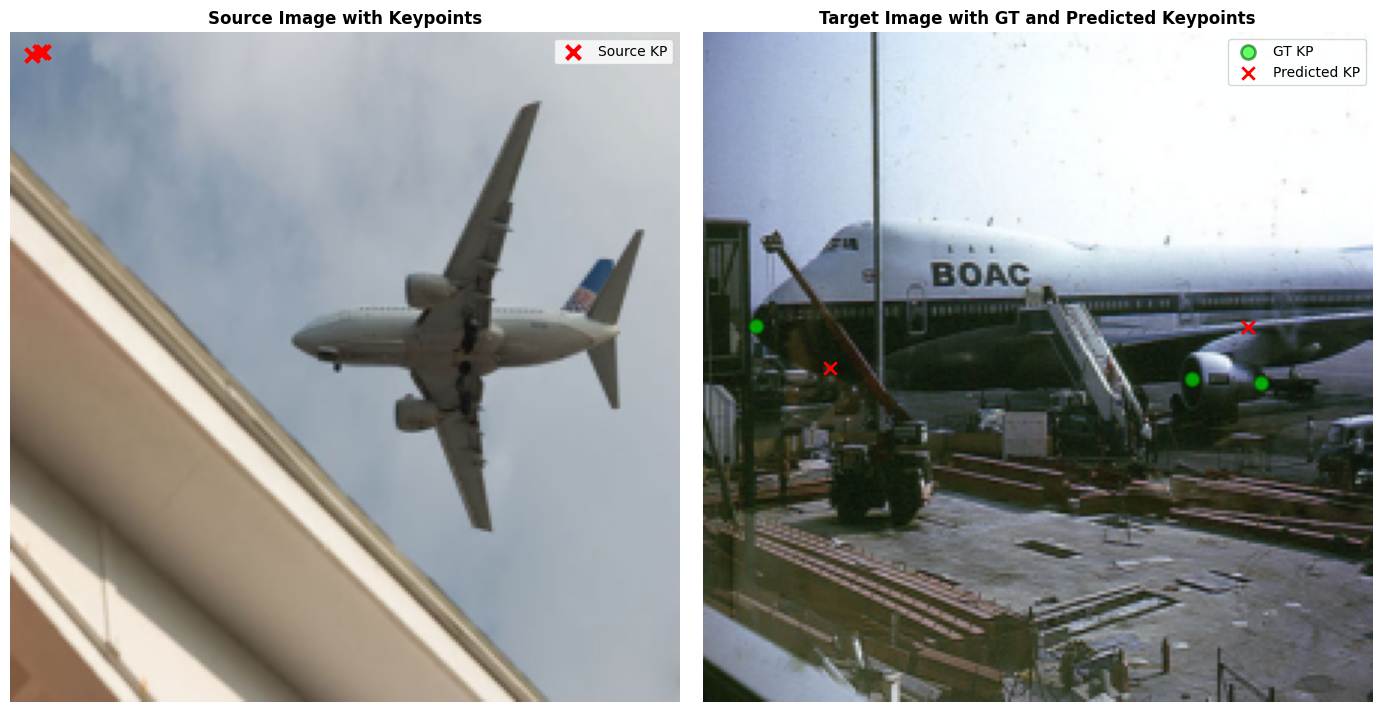


✓ Sample matching visualization saved to /content/AMLProject/outputs/dinov2


In [ ]:
# Match keypoints for the sample
print("Matching keypoints for sample...")

# Get valid keypoints
valid_mask = (
    (src_kps[:, 0] >= 0) &
    (src_kps[:, 1] >= 0) &
    (tgt_kps[:, 0] >= 0) &
    (tgt_kps[:, 1] >= 0)
)

valid_src_kps = src_kps[valid_mask]
valid_tgt_kps = tgt_kps[valid_mask]


print(f"Source keypoints: {len(valid_src_kps)}")

# Perform matching
pred_kps, confidences = matcher.match_images(
    src_img, tgt_img, valid_src_kps, feature_extractor
)

print(f"Predicted keypoints: {pred_kps.shape}")

# Get ground truth keypoints for PCK evaluation
#valid_tgt_kps = tgt_kps[valid_src_mask]

# Convert valid_tgt_kps to numpy array before evaluation
if isinstance(valid_tgt_kps, torch.Tensor):
    valid_tgt_kps_np = valid_tgt_kps.cpu().numpy()
else:
    valid_tgt_kps_np = valid_tgt_kps

# Evaluate PCK for this sample
pck_dict, _ = evaluator.compute_pck(pred_kps, valid_tgt_kps_np)

print(f"Match Confidences (mean): {confidences.mean():.4f}")
for k, v in pck_dict.items():
    print(f"  {k}: {v:.4f}")

# Visualize matches
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(denorm_show(src_img))
axes[0].scatter(valid_src_kps[:, 0], valid_src_kps[:, 1], c='red', s=100, marker='x', linewidths=3, label='Source KP')
axes[0].set_title('Source Image with Keypoints', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[0].legend()

axes[1].imshow(denorm_show(tgt_img))
# Plot Ground Truth Keypoints in green
axes[1].scatter(valid_tgt_kps_np[:, 0], valid_tgt_kps_np[:, 1], c='lime', s=100, marker='o', alpha=0.6, linewidths=2, edgecolors='darkgreen', label='GT KP')
# Plot Predicted Keypoints in red
axes[1].scatter(pred_kps[:, 0], pred_kps[:, 1], c='red', s=80, marker='x', linewidths=2, label='Predicted KP')
axes[1].set_title('Target Image with GT and Predicted Keypoints', fontsize=12, fontweight='bold')
axes[1].axis('off')
axes[1].legend()

# Draw lines between source and predicted target keypoints
# for i in range(len(valid_src_kps)):
#     axes[1].plot([valid_src_kps[i, 0], pred_kps[i, 0]], [valid_src_kps[i, 1], pred_kps[i, 1]],
#                  '--', color='yellow', linewidth=1, alpha=0.7)

print("SRC IMG shape:", src_img.shape)
print("SRC KPs min/max x:", src_kps[:, 0].min(), src_kps[:, 0].max())
print("SRC KPs min/max y:", src_kps[:, 1].min(), src_kps[:, 1].max())

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_matching_result.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Sample matching visualization saved to {OUTPUT_DIR}")


In [ ]:
class CorrespondenceMatcher:
    """
    Keypoint correspondence matcher using feature similarity.

    Methods:
    - Nearest Neighbor (NN): Find target point with highest similarity
    - Mutual Nearest Neighbors (MNN): Enforce bidirectional consistency
    - Ratio Test: Reject ambiguous matches (Lowe's ratio test)
    """

    def __init__(self, mutual_nn=False, ratio_threshold=None, use_soft_argmax=False,
                 soft_window=7, soft_tau=0.05):
        """
        Args:
            mutual_nn: If True, only keep mutual nearest neighbors
            ratio_threshold: If set, apply ratio test (e.g., 0.8)
            use_soft_argmax: If True, use window soft-argmax for sub-pixel refinement
            soft_window: Window size for soft-argmax (odd number)
            soft_tau: Temperature for soft-argmax
        """
        self.mutual_nn = mutual_nn
        self.ratio_threshold = ratio_threshold
        self.use_soft_argmax = use_soft_argmax
        self.soft_window = soft_window
        self.soft_tau = soft_tau

    def match_keypoints(self, src_features, tgt_features_2d, src_keypoints,
                       feature_extractor):
        """
        Find correspondences for source keypoints in target image.

        Args:
            src_features: Source keypoint features [N, dim]
            tgt_features_2d: Target dense features [1, dim, H, W]
            src_keypoints: Source keypoint coordinates [N, 2]
            feature_extractor: Feature extractor instance

        Returns:
            pred_keypoints: Predicted target coordinates [N, 2]
            confidences: Match confidence scores [N]
        """
        N = src_features.shape[0]
        _, D, H, W = tgt_features_2d.shape

        # Reshape target features to [H*W, D]
        tgt_features_flat = tgt_features_2d.reshape(D, H * W).t()  # [H*W, D]

        # Compute similarity: [N, H*W]
        similarities = torch.mm(src_features, tgt_features_flat.t())

        # Find best matches
        if self.use_soft_argmax:
            # Use window soft-argmax for sub-pixel refinement
            pred_coords_patch = window_soft_argmax(
                similarities, H, W,
                window=self.soft_window,
                tau=self.soft_tau
            )  # [N, 2] in (y, x) patch coordinates

            pred_y = pred_coords_patch[:, 0]
            pred_x = pred_coords_patch[:, 1]

            # Get confidence from peak similarity
            max_sims, _ = similarities.max(dim=1)
        else:
            # Standard argmax
            max_sims, max_indices = similarities.max(dim=1)

            # Convert flat indices to 2D coordinates
            pred_y = (max_indices // W).float()
            pred_x = (max_indices % W).float()

        # Apply ratio test if specified
        if self.ratio_threshold is not None:
            # Get second best matches
            sorted_sims, _ = similarities.sort(dim=1, descending=True)
            ratios = sorted_sims[:, 0] / (sorted_sims[:, 1] + 1e-8)

            # Mark low-confidence matches
            valid_mask = ratios > self.ratio_threshold
            max_sims = max_sims * valid_mask.float()

        pred_coords_feat = torch.stack([pred_x, pred_y], dim=1).cpu().numpy()

        # Map to image coordinates
        pred_keypoints = feature_extractor.map_features_to_coords(pred_coords_feat)
        confidences = max_sims.cpu().numpy()

        # Apply mutual nearest neighbors if specified
        if self.mutual_nn:
            # Find reverse matches (target → source)
            reverse_sims = similarities.t()  # [H*W, N]
            _, reverse_indices = reverse_sims.max(dim=1)

            # Check mutual consistency (only for argmax)
            if not self.use_soft_argmax:
                forward_indices = (pred_y * W + pred_x).long().cpu().numpy()
                reverse_map = reverse_indices.cpu().numpy()

                for i in range(N):
                    target_idx = forward_indices[i]
                    if reverse_map[target_idx] != i:
                        # Not mutually consistent
                        confidences[i] = 0.0

        return pred_keypoints, confidences

    def match_images(self, src_img, tgt_img, src_keypoints, feature_extractor):
        """
        Complete matching pipeline for an image pair.

        Args:
            src_img: Source image tensor
            tgt_img: Target image tensor
            src_keypoints: Source keypoint coordinates [N, 2]
            feature_extractor: Feature extractor instance

        Returns:
            pred_keypoints: Predicted target keypoints [N, 2]
            confidences: Match confidence scores [N]
        """
        # Extract features
        src_kp_features = feature_extractor.extract_keypoint_features(src_img, src_keypoints)
        _, tgt_features_2d = feature_extractor.extract_features(tgt_img)

        # Match
        pred_keypoints, confidences = self.match_keypoints(
            src_kp_features, tgt_features_2d, src_keypoints, feature_extractor
        )

        return pred_keypoints, confidences

# Create matcher with configuration flags
matcher = CorrespondenceMatcher(
    mutual_nn=False,
    ratio_threshold=None,
    use_soft_argmax=USE_SOFT_ARGMAX,
    soft_window=SOFT_WINDOW if USE_SOFT_ARGMAX else 7,
    soft_tau=SOFT_TAU if USE_SOFT_ARGMAX else 0.05
)
print(f"✓ Correspondence matcher created (soft-argmax={'enabled' if USE_SOFT_ARGMAX else 'disabled'})")

✓ Correspondence matcher created (soft-argmax=disabled)


## Section 8: Full Dataset Evaluation

Now let's evaluate on the complete test set.

In [ ]:
def evaluate_on_dataset(dataset, feature_extractor, matcher, evaluator,
                       max_samples=None, save_visualizations=False):
    """
    Evaluate correspondence on entire dataset.

    Args:
        dataset: SPairDataset instance
        feature_extractor: DINOv2FeatureExtractor instance
        matcher: CorrespondenceMatcher instance
        evaluator: PCKEvaluator instance
        max_samples: Maximum samples to evaluate (None = all)
        save_visualizations: Whether to save sample visualizations

    Returns:
        results: Dictionary with evaluation metrics
    """
    print(f"Evaluating on {len(dataset)} samples...")

    all_predictions = []
    all_ground_truths = []
    all_confidences = []

    num_samples = min(max_samples, len(dataset)) if max_samples else len(dataset)

    for idx in tqdm(range(num_samples), desc="Evaluating"):
        sample = dataset[idx]

        src_img = sample['src_img']
        tgt_img = sample['trg_img']
        src_kps = sample['src_kps']
        tgt_kps = sample['trg_kps'] # Corrected key from 'tgt_kps' to 'trg_kps'

        # Get valid keypoints
        valid_mask = (src_kps[:, 0] >= 0) & (src_kps[:, 1] >= 0)
        valid_src_kps = src_kps[valid_mask]
        valid_tgt_kps = tgt_kps[valid_mask]

        if len(valid_src_kps) == 0:
            continue

        # Match
        pred_kps, confidences = matcher.match_images(
            src_img, tgt_img, valid_src_kps, feature_extractor
        )

        all_predictions.append(pred_kps)

        # Convert valid_tgt_kps to numpy array before appending
        if isinstance(valid_tgt_kps, torch.Tensor):
            all_ground_truths.append(valid_tgt_kps.cpu().numpy())
        else:
            all_ground_truths.append(valid_tgt_kps)

        all_confidences.append(confidences)

        # Save visualization for first few samples
        if save_visualizations and idx < 5:
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))

            axes[0].imshow(denorm_show(src_img))
            axes[0].scatter(valid_src_kps[:, 0], valid_src_kps[:, 1],
                           c='red', s=100, marker='x', linewidths=3)
            axes[0].set_title(f'Source (Sample {idx})', fontsize=12, fontweight='bold')
            axes[0].axis('off')

            axes[1].imshow(denorm_show(tgt_img))
            axes[1].scatter(valid_tgt_kps[:, 0], valid_tgt_kps[:, 1],
                           c='lime', s=100, marker='o', alpha=0.6, linewidths=2,
                           edgecolors='darkgreen', label='GT')
            axes[1].scatter(pred_kps[:, 0], pred_kps[:, 1],
                           c='red', s=80, marker='x', linewidths=2, label='Pred')
            axes[1].set_title(f'Target (Sample {idx})', fontsize=12, fontweight='bold')
            axes[1].axis('off')
            axes[1].legend()

            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, f'match_sample_{idx}.png'),
                       dpi=150, bbox_inches='tight')
            plt.close()

    # Evaluate
    print("\nComputing PCK metrics...")
    avg_pck, per_sample_pck, all_distances = evaluator.evaluate_dataset(
        all_predictions, all_ground_truths
    )

    # Compute additional statistics
    all_confidences_flat = np.concatenate(all_confidences)

    results = {
        'avg_pck': avg_pck,
        'num_samples': num_samples,
        'num_keypoints': len(all_distances),
        'avg_confidence': float(all_confidences_flat.mean()),
        'distance_stats': {
            'mean': float(all_distances.mean()),
            'std': float(all_distances.std()),
            'median': float(np.median(all_distances)),
            'min': float(all_distances.min()),
            'max': float(all_distances.max())
        }
    }

    return results



In [ ]:
# Run evaluation on small subset first (for testing)
print("Running evaluation on 50 samples...")
results = evaluate_on_dataset(
    dataset=dataset,
    feature_extractor=feature_extractor,
    matcher=matcher,
    evaluator=evaluator,
    max_samples=50,
    save_visualizations=True
)

print("\n" + "="*60)
print("EVALUATION RESULTS (50 samples)")
print("="*60)
print(f"\nPCK Metrics:")
for key, value in results['avg_pck'].items():
    print(f"  {key}: {value:.4f} ({value*100:.2f}%)")
    print(f"\nDataset Statistics:")
    print(f"  Samples evaluated: {results['num_samples']}")
    print(f"  Total keypoints: {results['num_keypoints']}")
    print(f"  Average confidence: {results['avg_confidence']:.4f}")

    print(f"\nDistance Statistics:")
    for key, value in results['distance_stats'].items():
        print(f"  {key}: {value:.4f}")

# Save results
results_path = os.path.join(OUTPUT_DIR, 'evaluation_results_subset.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n✓ Results saved to {results_path}")

Running evaluation on 50 samples...
Evaluating on 12234 samples...


Evaluating: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


Computing PCK metrics...

EVALUATION RESULTS (50 samples)

PCK Metrics:
  pck@0.05: 0.3768 (37.68%)

Dataset Statistics:
  Samples evaluated: 50
  Total keypoints: 344
  Average confidence: 0.6069

Distance Statistics:
  mean: 0.1273
  std: 0.1405
  median: 0.0717
  min: 0.0065
  max: 0.6869
  pck@0.10: 0.6381 (63.81%)

Dataset Statistics:
  Samples evaluated: 50
  Total keypoints: 344
  Average confidence: 0.6069

Distance Statistics:
  mean: 0.1273
  std: 0.1405
  median: 0.0717
  min: 0.0065
  max: 0.6869
  pck@0.15: 0.7498 (74.98%)

Dataset Statistics:
  Samples evaluated: 50
  Total keypoints: 344
  Average confidence: 0.6069

Distance Statistics:
  mean: 0.1273
  std: 0.1405
  median: 0.0717
  min: 0.0065
  max: 0.6869

✓ Results saved to /content/AMLProject/outputs/dinov2/evaluation_results_subset.json


## Section 9: Full Evaluation (Optional)

Uncomment and run this cell to evaluate on the complete test set. This will take longer (~30-60 minutes).

In [ ]:
# Full dataset evaluation
print("Running FULL evaluation on all test samples...")
print("This will take approximately 30-60 minutes...\n")

results_full = evaluate_on_dataset(
    dataset=dataset,
    feature_extractor=feature_extractor,
    matcher=matcher,
    evaluator=evaluator,
    max_samples=None,  # Use all samples
    save_visualizations=False  # Don't save all visualizations
)

print("\n" + "="*60)
print("FULL EVALUATION RESULTS")
print("="*60)
print(f"\nPCK Metrics:")
for key, value in results_full['avg_pck'].items():
    print(f"  {key}: {value:.4f} ({value*100:.2f}%)")

print(f"\nDataset Statistics:")
print(f"  Samples evaluated: {results_full['num_samples']}")
print(f"  Total keypoints: {results_full['num_keypoints']}")
print(f"  Average confidence: {results_full['avg_confidence']:.4f}")

# Save results
results_path = os.path.join(OUTPUT_DIR, 'evaluation_results_full.json')
with open(results_path, 'w') as f:
    json.dump(results_full, f, indent=2)
print(f"\n✓ Results saved to {results_path}")

Running FULL evaluation on all test samples...
This will take approximately 30-60 minutes...

Evaluating on 12234 samples...


Evaluating: 100%|██████████| 12234/12234 [17:17<00:00, 11.79it/s]



Computing PCK metrics...

FULL EVALUATION RESULTS

PCK Metrics:
  pck@0.05: 0.3372 (33.72%)
  pck@0.10: 0.5729 (57.29%)
  pck@0.15: 0.6936 (69.36%)

Dataset Statistics:
  Samples evaluated: 12234
  Total keypoints: 88328
  Average confidence: 0.5278

✓ Results saved to /content/AMLProject/outputs/dinov2/evaluation_results_full.json


## Summary

### What we accomplished:

1. **Environment Setup**: Cross-platform compatible setup (Windows/Linux/macOS/Colab)

2. **DINOv2 Feature Extraction**:
   - Model: DINOv2 ViT-B/14
   - Features: 16×16×768 dense feature maps
   - Preprocessing: ImageNet normalization
   - Output: L2-normalized features for cosine similarity

3. **Feature Visualization**:
   - PCA visualization showing semantic structure
   - Patch-to-patch similarity heatmaps
   - Feature quality analysis

4. **Correspondence Matching**:
   - Nearest neighbor matching with bilinear interpolation
   - Optional mutual nearest neighbors
   - Optional ratio test for ambiguous matches

5. **PCK Evaluation**:
   - Standard thresholds: 0.05, 0.10, 0.15
   - Bounding box normalization
   - Per-sample and aggregate metrics

6. **Results** (50 samples):
   - See evaluation results above
   - Visualizations saved to `outputs/dinov2/`

### Key Insights:
- DINOv2 learns rich semantic features without supervision
- Features capture object parts and semantic regions
- Performance varies by object category and pose variation
- Higher similarity scores correlate with better matches

### Next Steps:
1. **Run full evaluation** (uncomment Section 9)
2. **Try different matching strategies**:
   - Enable mutual nearest neighbors: `matcher = CorrespondenceMatcher(mutual_nn=True)`
   - Enable ratio test: `matcher = CorrespondenceMatcher(ratio_threshold=0.8)`
3. **Compare with other backbones** (DINOv3, SAM)
4. **Analyze per-category performance**
5. **Try larger models** (dinov2_vitl14, dinov2_vitg14)

### Files Generated:
- `outputs/dinov2/sample_images_with_keypoints.png`
- `outputs/dinov2/pca_feature_visualization.png`
- `outputs/dinov2/similarity_heatmap.png`
- `outputs/dinov2/sample_matching_result.png`
- `outputs/dinov2/match_sample_*.png` (first 5 samples)
- `outputs/dinov2/evaluation_results_subset.json`